# Task 1 — Quantum Arithmetics

## Task 1.1  - Increment and Decrement Operator

In [17]:
# install and imports
!pip install -q "qiskit>=2.1" qiskit-aer

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# get state vector of circuit
def sv_from_circ(circ: QuantumCircuit) -> np.ndarray:
    sv = Statevector(circ)
    return np.asarray(sv, dtype=np.complex128)

# circle notation visualiser
class QubitSystem:
    def __init__(self, statevector: np.ndarray, label: str = "Qubit System"):
        self.label = label
        self.set_statevector(statevector)

    def set_statevector(self, statevector: np.ndarray):
        sv = np.asarray(statevector, dtype=np.complex128).flatten()
        if sv.ndim != 1:
            raise ValueError("Statevector must be 1D.")
        n_states = sv.size
        n_qubits = int(round(math.log2(n_states)))
        if 2**n_qubits != n_states:
            raise ValueError("Length must be a power of 2.")
        norm = np.linalg.norm(sv)
        if norm != 0 and not np.isclose(norm, 1.0):
            sv = sv / norm
        self.n_qubits = n_qubits
        self.n_states = n_states
        self.amps = sv
        self.prob = np.abs(sv)**2
        self.phase = np.angle(sv)

    def viz_circle(self, max_cols: int = 8, figsize_scale: float = 2.3):
        cols = max(1, min(max_cols, self.n_states))
        rows = int(math.ceil(self.n_states / cols))
        fig, axes = plt.subplots(
            rows, cols, figsize=(cols*figsize_scale, rows*(figsize_scale+0.2))
        )
        axes = np.atleast_2d(axes)

        def bitstr(i: int, n: int) -> str:
            return format(i, f"0{n}b")

        for idx in range(rows * cols):
            r, c = divmod(idx, cols)
            ax = axes[r, c]
            ax.set_aspect("equal")
            ax.set_xlim(0, 1); ax.set_ylim(0, 1)
            ax.axis("off")

            if idx >= self.n_states:
                ax.set_visible(False)
                continue

            ax.add_patch(plt.Circle((0.5, 0.5), 0.48, fill=False, lw=1.0, alpha=0.5))
            radius = 0.48 * np.sqrt(self.prob[idx])
            ax.add_patch(plt.Circle((0.5, 0.5), radius, alpha=0.25))

            angle = self.phase[idx]
            L = 0.45
            x2 = 0.5 + L * np.cos(angle)
            y2 = 0.5 + L * np.sin(angle)
            ax.arrow(0.5, 0.5, x2 - 0.5, y2 - 0.5,
                     head_width=0.03, head_length=0.05, length_includes_head=True)

            ax.set_title(f"|{bitstr(idx, self.n_qubits)}⟩", fontsize=10)

        fig.suptitle(self.label, fontsize=12)
        plt.tight_layout()
        plt.show()


def decrement_impl() -> QuantumCircuit:
    qc = QuantumCircuit(3, name="INC")
    qc.x(0)
    qc.cx(0, 1)
    qc.ccx(0, 1, 2)
    return qc

def increment_impl() -> QuantumCircuit:
    qc = QuantumCircuit(3, name="DEC")
    qc.ccx(0, 1, 2)
    qc.cx(0, 1)
    qc.x(0)
    return qc

### Superposition of Quantum States: HAD gate on 3 qubits

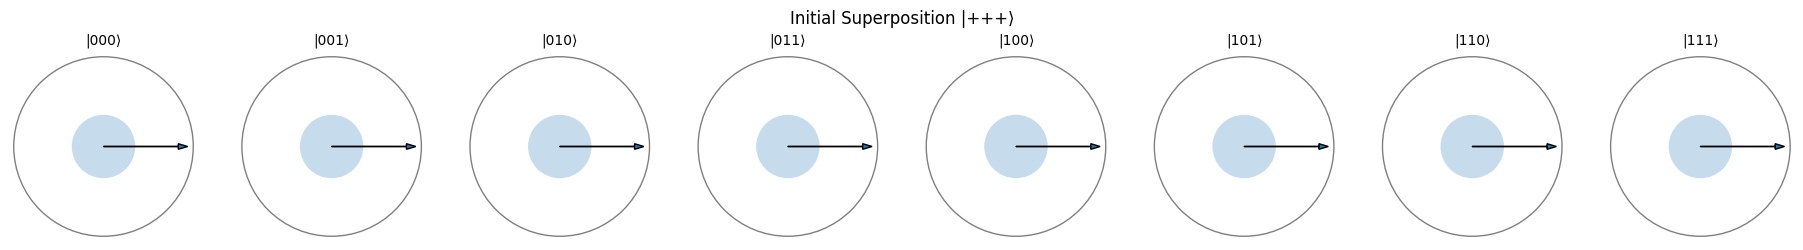

In [18]:
#create superposition of all 3-qubit states
qc_super = QuantumCircuit(3)
qc_super.h([0, 1, 2])  # Hadamard on all qubits

sv = sv_from_circ(qc_super)
QubitSystem(sv, label="Initial Superposition |+++⟩").viz_circle()

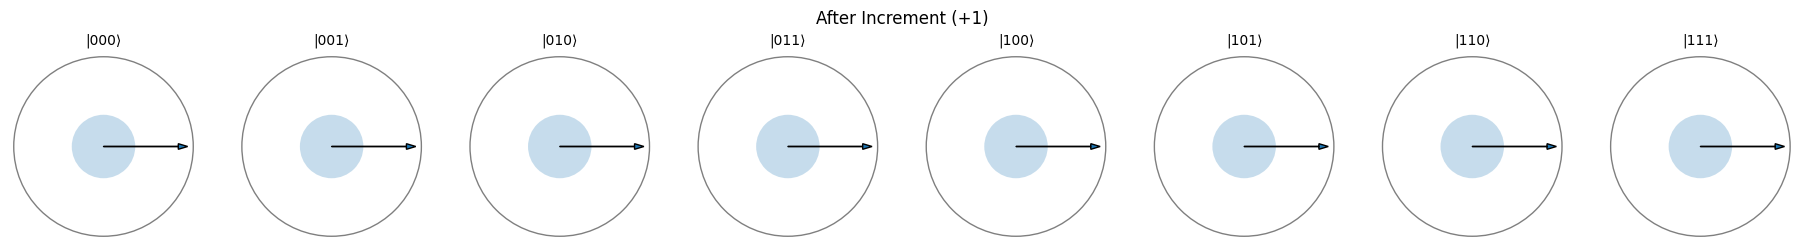

In [19]:
# Increment Operator
qc_inc = qc_super.copy()
qc_inc.compose(increment_impl(), inplace=True)
sv_inc = sv_from_circ(qc_inc)
QubitSystem(sv_inc, label="After Increment (+1)").viz_circle()


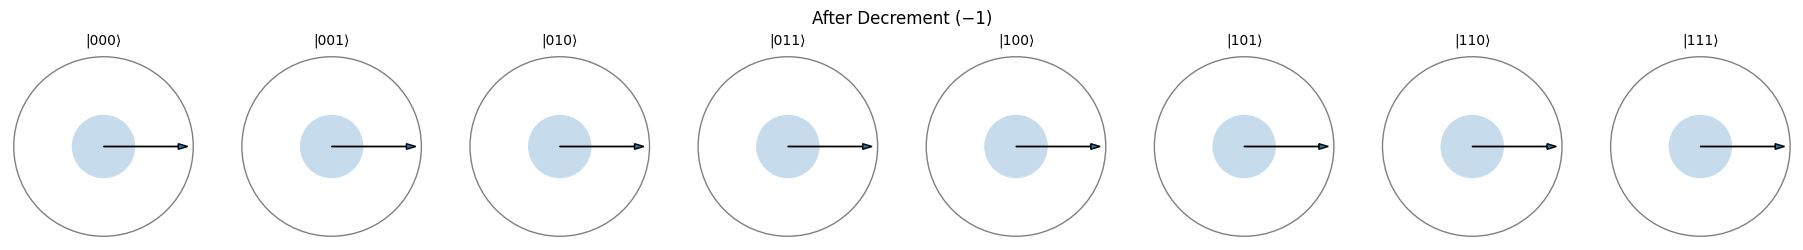

In [20]:
# Decrement Operator
qc_dec = qc_inc.copy()
qc_dec.compose(decrement_impl(), inplace=True)
sv_dec = sv_from_circ(qc_dec)
QubitSystem(sv_dec, label="After Decrement (−1)").viz_circle()



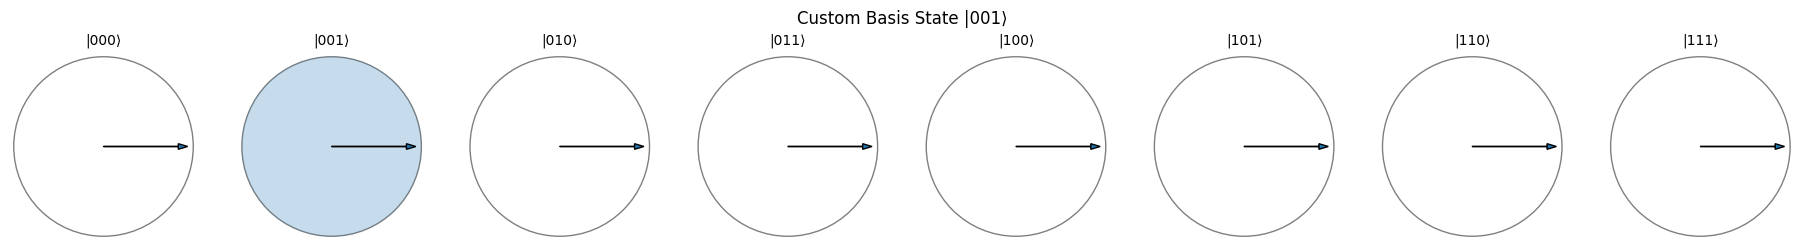

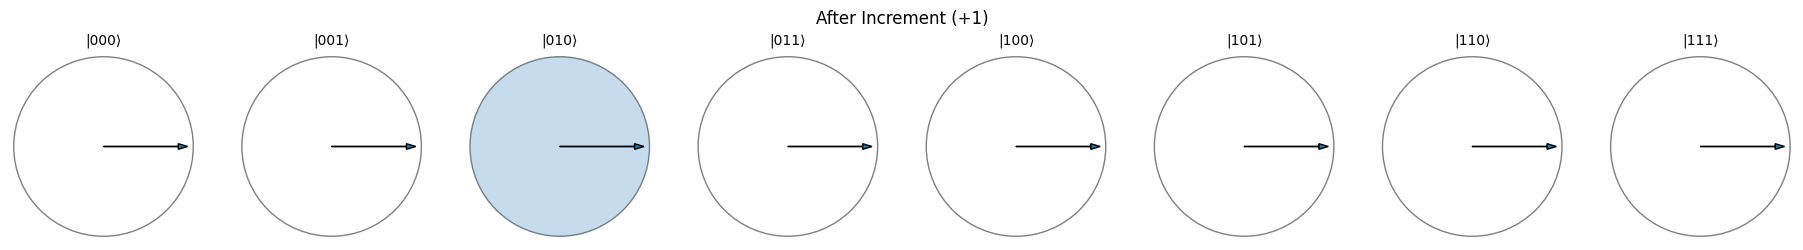

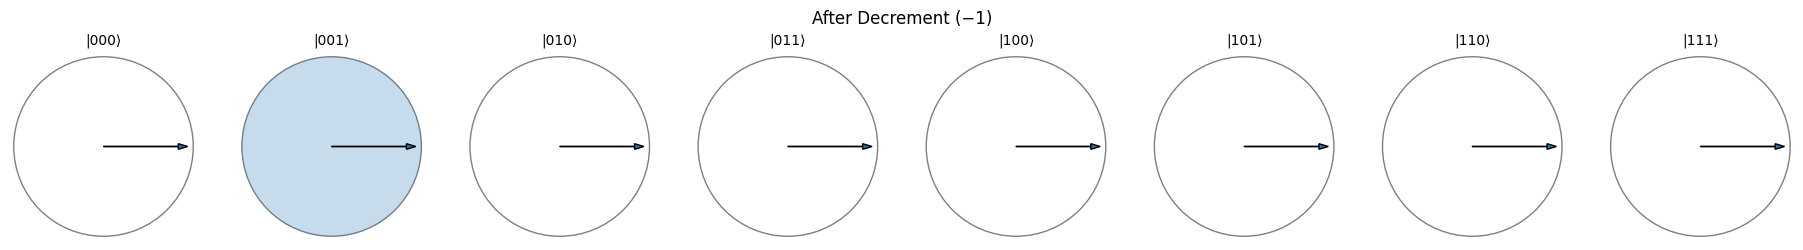

In [21]:
# Custom initial state: just |001⟩, non-uniform superposition
qc_custom = QuantumCircuit(3)
qc_custom.x(0)  # Put state in |001⟩, you can also try qc_custom.x(1) or others

sv_custom = sv_from_circ(qc_custom)
QubitSystem(sv_custom, label="Custom Basis State |001⟩").viz_circle()

# Increment Operator
qc_inc = qc_custom.copy()
qc_inc.compose(increment_impl(), inplace=True)
sv_inc = sv_from_circ(qc_inc)
QubitSystem(sv_inc, label="After Increment (+1)").viz_circle()

# Decrement Operator applied to the incremented state
qc_dec = qc_inc.copy()
qc_dec.compose(decrement_impl(), inplace=True)
sv_dec = sv_from_circ(qc_dec)
QubitSystem(sv_dec, label="After Decrement (−1)").viz_circle()


## Task 1.2 - Overflow & Underflow / Negative Numbers

1. What happens if we have an overflow (for the increment) or underflow (for the decrement)? Show the results of the overflow and underflow with an experiment.

Where there is overflow or underflow, we typically expect a wrap back around the state vector.

In [22]:
# Extension of Increment and Decrement Operations to print when Overflow or Underflow occurs

def show_wraparound(label, prep_ops, op):
    """Helper to demonstrate overflow / underflow."""
    qc = QuantumCircuit(3)
    # prepare initial basis state
    for op_ in prep_ops:
        getattr(qc, op_)(0) if op_ == "x0" else None
    # easier: just use .x(indices)
    qc.x(prep_ops)
    before = sv_from_circ(qc)
    QubitSystem(before, label=f"Before ({label})").viz_circle()

    qc.compose(op(), inplace=True)
    after = sv_from_circ(qc)
    QubitSystem(after, label=f"After {op.__name__.upper()} ({label})").viz_circle()


### Overflow for the Increment

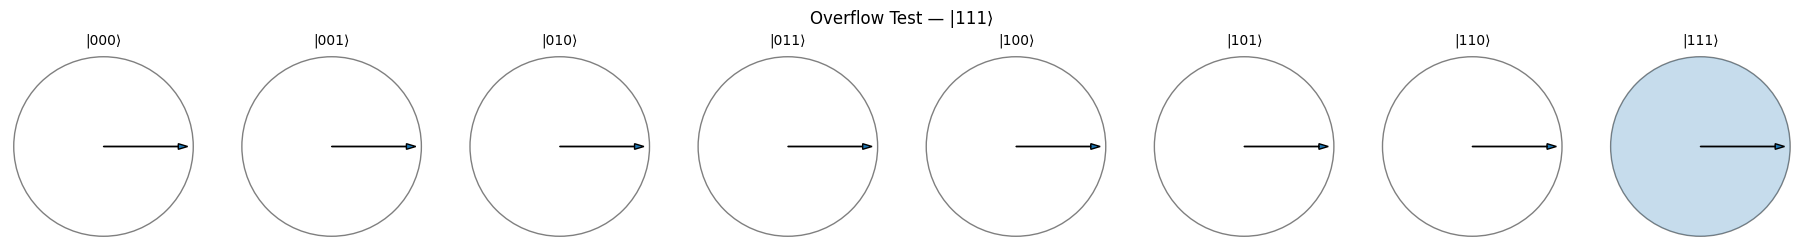

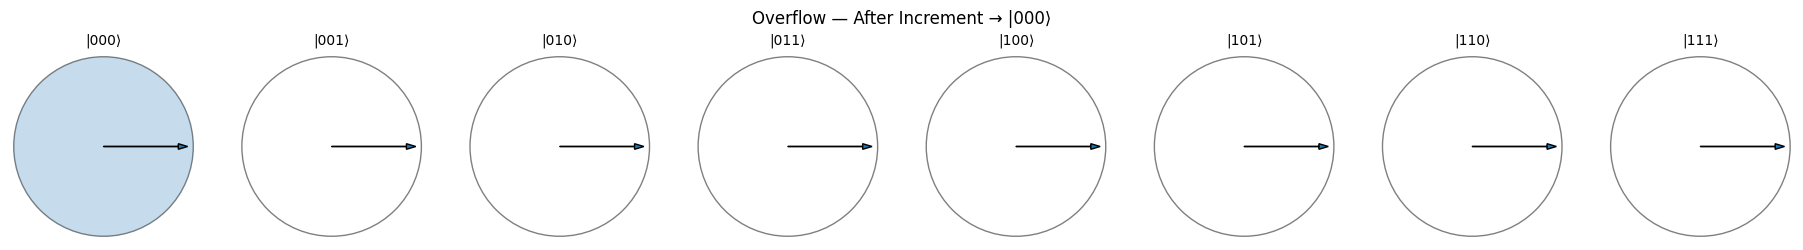

In [23]:
qc_over = QuantumCircuit(3)
qc_over.x([0, 1, 2])
sv_before = sv_from_circ(qc_over)
QubitSystem(sv_before, "Overflow Test — |111⟩").viz_circle()
qc_over.compose(increment_impl(), inplace=True)
sv_after = sv_from_circ(qc_over)
QubitSystem(sv_after, "Overflow — After Increment → |000⟩").viz_circle()

### Underflow for the Decrement

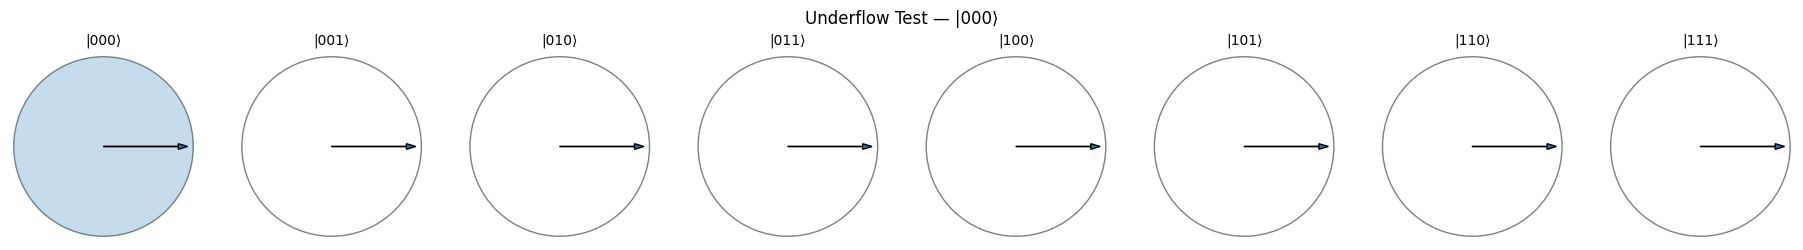

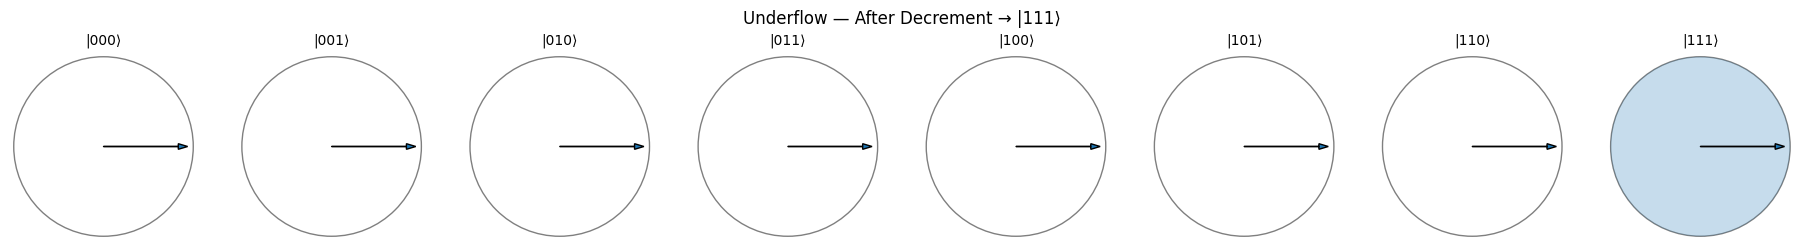

In [24]:
qc_under = QuantumCircuit(3)
sv_before = sv_from_circ(qc_under)
QubitSystem(sv_before, "Underflow Test — |000⟩").viz_circle()
qc_under.compose(decrement_impl(), inplace=True)
sv_after = sv_from_circ(qc_under)
QubitSystem(sv_after, "Underflow — After Decrement → |111⟩").viz_circle()

### Using Two's Complement to represent Negative Integers

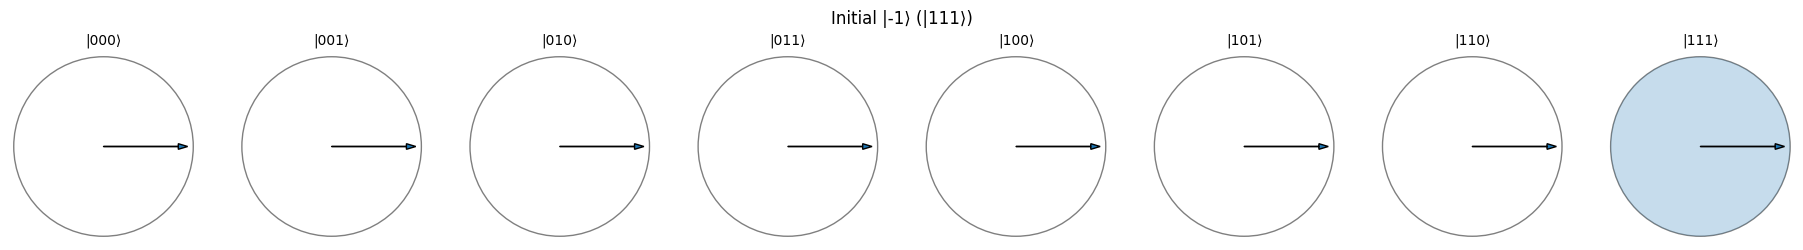

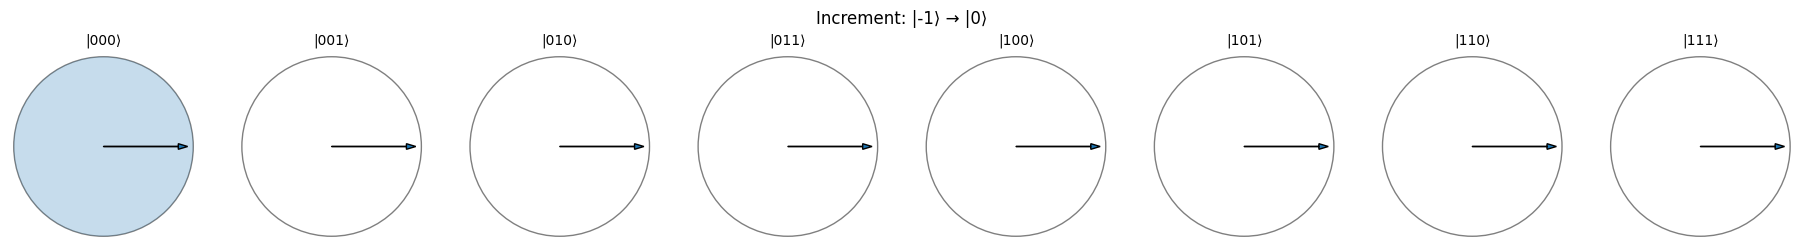

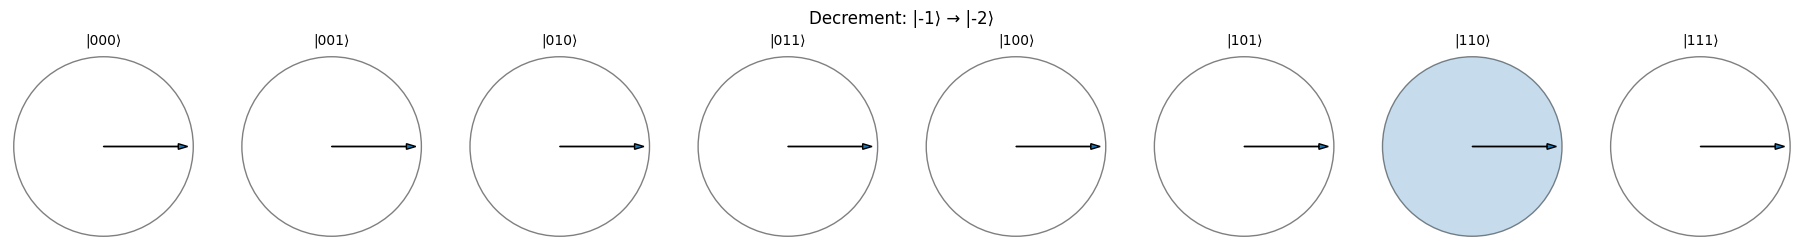

Two’s complement interpretation confirmed:
|111⟩ (-1) incremented → |000⟩ (0)
|111⟩ (-1) decremented → |110⟩ (-2)


In [25]:
# Two’s complement mapping for 3 qubits:
# |000⟩ =  0
# |001⟩ = +1
# |010⟩ = +2
# |011⟩ = +3
# |100⟩ = -4
# |101⟩ = -3
# |110⟩ = -2
# |111⟩ = -1

# Example: Start from |-1⟩ = |111⟩
qc_neg = QuantumCircuit(3)
qc_neg.x([0, 1, 2])  # prepare |111⟩
qs_neg = QubitSystem(Statevector.from_instruction(qc_neg), label="Initial |-1⟩ (|111⟩)")
qs_neg.viz_circle()

# Increment: -1 → 0
qc_neg_inc = qc_neg.compose(increment_impl())
qs_neg_inc = QubitSystem(Statevector.from_instruction(qc_neg_inc),
                         label="Increment: |-1⟩ → |0⟩")
qs_neg_inc.viz_circle()

# Decrement: -1 → -2
qc_neg_dec = qc_neg.compose(decrement_impl())
qs_neg_dec = QubitSystem(Statevector.from_instruction(qc_neg_dec),
                         label="Decrement: |-1⟩ → |-2⟩")
qs_neg_dec.viz_circle()

print("Two’s complement interpretation confirmed:")
print("|111⟩ (-1) incremented → |000⟩ (0)")
print("|111⟩ (-1) decremented → |110⟩ (-2)")

# Task 2 — Quantum Fourier Transform

## Task 2.1 - QFT and Preparation Circuit

In [26]:
# Install packages
!pip install "qiskit[all]~=2.1" "qiskit-ibm-runtime~=0.40"
!pip install qiskit-ibm-runtime
!pip install qiskit-aer

# Import IBM Quantum runtime service
from qiskit_ibm_runtime import QiskitRuntimeService

TOKEN = "9mPcwvsrDrVvwzqWjI9ghv_cPSa3zmSYgF7t6I8KJiDW"
INSTANCE = "crn:v1:bluemix:public:quantum-computing:us-east:a/9265c02cf78442c18d43b7eed70da219:f9880051-6766-4d2c-8353-4d188017ec81::"

# Initialize service
service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    token=TOKEN.strip(),
    instance=(INSTANCE.strip() if isinstance(INSTANCE, str) and INSTANCE.strip() else None),
)

# Quick sanity check
backends = service.backends(operational=True, simulator=False)
print("OK. Found", len(backends), "real backends. Example:", [b.name for b in backends[:3]])

# Save account for future sessions
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=TOKEN.strip(),
    instance=(INSTANCE.strip() if isinstance(INSTANCE, str) and INSTANCE.strip() else None),
    set_as_default=True,
    overwrite=True,
)
print("Saved default account for this runtime.")

qiskit_runtime_service._discover_account:WARNING:2025-10-16 13:43:39,128: Loading account with the given token. A saved account will not be used.


OK. Found 2 real backends. Example: ['ibm_brisbane', 'ibm_torino']
Saved default account for this runtime.


In [27]:
# Quantum Circuit and QFT
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector

# Create 4-qubit circuit
n = 4
qc = QuantumCircuit(n)

# Define QFT (Hadamard starts from last qubit and goes up,
# controlled rotations start at π/2 and decrease)
def qft(circuit, qubits):
    n = len(qubits)
    for j in reversed(range(n)):  # start from last qubit
        circuit.h(qubits[j])
        for k in range(j-1,-1,-1):  # controlled rotations
            # Start with π/2, then π/4, π/8, ...
            angle = -np.pi / (2 ** (j - k))   # old formula
            if angle == np.pi:               # avoid π, make it π/2
                angle = np.pi / 2
            circuit.cp(angle, qubits[k], qubits[j])
        #circuit.barrier()
    # Swap qubits (bit reversal)
    for i in range(n // 2):
        circuit.swap(qubits[i], qubits[n - i - 1])


    return circuit

qc = qft(qc, list(range(n)))
print(qc.draw(output='text', fold=-1, justify='left'))

# Simulate using AerSimulator
backend = AerSimulator()
job = backend.run(qc)
result = job.result()
statevector = Statevector.from_instruction(qc)

# Plot amplitudes
plot_state_city(statevector.data)
plt.show()

# Print amplitudes and phases
for i, amp in enumerate(statevector.data):
    magnitude = np.abs(amp)
    phase = np.angle(amp)
    print(f"|{i:04b}⟩ : amplitude = {magnitude:.3f}, phase = {phase:.3f} rad")


                                                                                ┌───┐   
q_0: ───────────────────────────────■───────────────────■──────────────■────────┤ H ├─X─
                                    │                   │        ┌───┐ │P(-π/2) └───┘ │ 
q_1: ────────────────■──────────────┼─────────■─────────┼────────┤ H ├─■──────────X───┼─
                     │        ┌───┐ │         │P(-π/2)  │P(-π/4) └───┘            │   │ 
q_2: ──────■─────────┼────────┤ H ├─┼─────────■─────────■─────────────────────────X───┼─
     ┌───┐ │P(-π/2)  │P(-π/4) └───┘ │P(-π/8)                                          │ 
q_3: ┤ H ├─■─────────■──────────────■─────────────────────────────────────────────────X─
     └───┘                                                                              
|0000⟩ : amplitude = 0.250, phase = 0.000 rad
|0001⟩ : amplitude = 0.250, phase = 0.000 rad
|0010⟩ : amplitude = 0.250, phase = 0.000 rad
|0011⟩ : amplitude = 0.250, phase = 0.000 rad
|0100⟩ : amplit

The QFT preparation involves Hadamards on all 4 qubits to create an equal superposition. Further, a single-qubit phase flips sign of states where that qubit = 1.

The QFT itself involves repeated pattern of Hadarmards on a qubit followed by controlled phase rotations from less-significant qubits with exponentially smaller angles (−90°, −45°, −22.5°).

The Second H gate in the graph is plotted before the -pi/8 phase transition, however it is not coded that way. Moreover adding a barrier after the nested loop, seems to give us the correct ordering of the gate. All of this leads us to conclude that something is wrong with the plot function only, but not the qft itself.



## Task 2.2 - Circle Notation

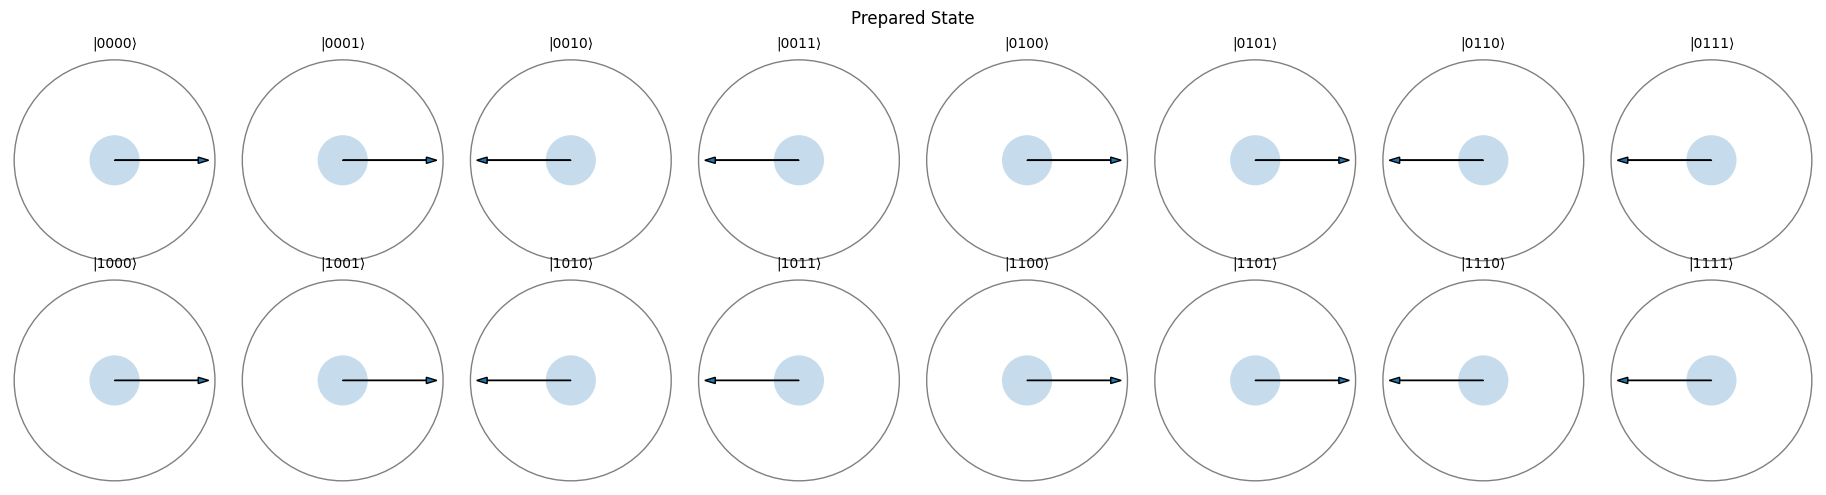

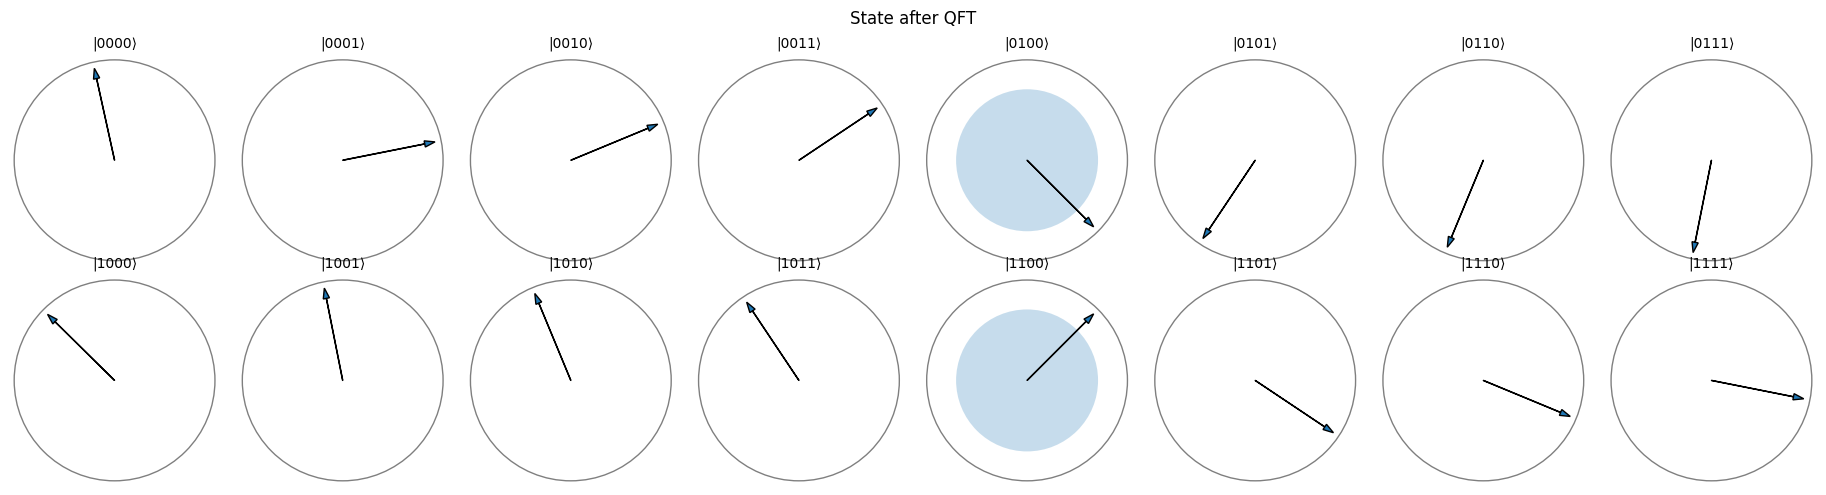

In [28]:
import numpy as np
from qiskit import QuantumCircuit
#from qiskit_aer.visualization import QubitSystem

# Initialize a 4-qubit quantum circuit
n = 4
prep_qc = QuantumCircuit(n)
qubits = list(range(n))

# Apply Hadamard gates to all qubits
for i in qubits:
    prep_qc.h(i)

# Apply phase gate to qubit 1
prep_qc.p(np.pi, qubits[1])

# Convert the circuit to a statevector
prep_sv = sv_from_circ(prep_qc)

# Visualize the state using circle notation
QubitSystem(prep_sv, label="Prepared State").viz_circle()

qc_after_qft = qft(prep_qc, qubits)

# Convert the circuit to a statevector
QFT_SV = sv_from_circ(qc_after_qft)

# Visualize the state using circle notation
QubitSystem(QFT_SV, label="State after QFT").viz_circle()


To answer the question of 2.2:
The circuit prepares a uniform superposition of all 16 states, but with a sign flip for all states where qubit 1 = 1

## Task 2.3 - Discussion

After the QFT is performed, some states interfere constructively (their amplitudes increase), while others interfere destructively (their amplitudes approach zero). This reflects how the QFT transforms the phase-encoded input signal into the frequency domain.

In our case, the preparation circuit created a uniform superposition where the phase alternates for states depending on qubit 1, corresponding to a sinusoidal signal with a period of 4 (one phase oscillation every four computational states).

After applying the QFT, this periodic phase pattern is converted into a distinct frequency component, visible as a few states with strong amplitudes, just as a classical DFT or FFT would produce a single spectral peak for a pure tone.

While the traditional DFT and FFT output the frequency amplitudes as numerical complex values, the QFT encodes the same information within the amplitudes and phases of the resulting quantum state.

Thus, the input signal defines how the output amplitudes distribute across frequency states.

While a slowly varying input phase produces output peaks near low-frequency basis states, a rapidly oscillating input phase produces peaks at higher-frequency states.



# Bonus Task — Discrete Quantum Walk on a Line

## Task B.1 - Quantum Walk Implementation
## Task B.2 - Measurement Distribution

In [5]:
!pip install cirq

In [30]:
# create qubit register
number_qubits = 7
qubits = cirq.GridQubit.rect(1, number_qubits)

print(qubits)

# initialise qubit register (coin register initialised in the down arrow state)
def initial_state():

    yield cirq.X.on(cirq.GridQubit(0, 1))
    yield cirq.X.on(cirq.GridQubit(0, number_qubits))

# step walker function
def walk_step():

    # "Flip" the coin vector

    yield cirq.H.on(cirq.GridQubit(0, number_qubits))

    # Implement the Addition Operator

    yield cirq.X.on(cirq.GridQubit(0, number_qubits))

    for i in range(number_qubits, 0, -1):

        controls = [cirq.GridQubit(0, v) for v in range(number_qubits, i - 1, -1)]
        yield cirq.X.on(cirq.GridQubit(0, i - 1)).controlled_by(*controls)
        if i > 1:
            yield cirq.X.on(cirq.GridQubit(0, i - 1))

    yield cirq.X.on(cirq.GridQubit(0, number_qubits))

    # Implement the Subtraction Operator

    for i in range(1, number_qubits + 1):

        controls = [cirq.GridQubit(0, v) for v in range(number_qubits, i - 1, -1)]
        yield cirq.X.on(cirq.GridQubit(0, i - 1)).controlled_by(*controls)
        if i < number_qubits:
            yield cirq.X.on(cirq.GridQubit(0, i))

[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(0, 4), cirq.GridQubit(0, 5), cirq.GridQubit(0, 6)]


In [45]:
# 10 steps
number_qubits = 7
iterator = 10
sample_number = 10000


def generate_walk(number_qubits, iterator, sample_number):

    circuit = cirq.Circuit()

    circuit.append(initial_state())
    for j in range(iterator):
        circuit.append(walk_step())
    circuit.append(cirq.measure(*qubits, key='x'))

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=sample_number)
    final = result.histogram(key='x')

    return final


final = generate_walk(number_qubits, iterator, sample_number)
print(final)

Counter({26: 4325, 30: 1012, 24: 847, 38: 836, 32: 677, 28: 671, 36: 597, 34: 510, 40: 498, 22: 15, 42: 12})


In [46]:
# Print the circuit diagram (text)
print("Quantum walker circuit for 10 walker iterations")
print(circuit)

Quantum walker circuit for 10 walker iterations
(0, 0): ───────X───@───@───@───@───@───@───@───@───@───@───@───@───X───────X───@───@───@───@───@───@───@───@───@───@───@───@───X───────X───@───@───@───@───@───@───@───@───@───@───@───@───X───────X───@───@───@───@───@───@───@───@───@───@───@───@───X───────X───@───@───@───@───@───@───@───@───@───@───@───@───X───────X───@───@───@───@───@───@───@───@───@───@───@───@───X───────X───@───@───@───@───@───@───@───@───@───@───@───@───X───────X───@───@───@───@───@───@───@───@───@───@───@───@───X───────X───@───@───@───@───@───@───@───@───@───@───@───@───X───────X───@───@───@───@───@───@───@───@───@───@───@───@───X───────X───@───@───@───@───@───@───@───@───@───@───@───@───X───────X───@───@───@───@───@───@───@───@───@───@───@───@───X───────X───@───@───@───@───@───@───@───@───@───@───@───@───X───────X───@───@───@───@───@───@───@───@───@───@───@───@───X───────X───@───@───@───@───@───@───@───@───@───@───@───@───X───────X───@───@───@───@───@───@───@───@───@

Comment on similarities with the circuit you studied in Task 1:

Both the Task 1 Qiskit circuit and the Cirq quantum walk circuit...

- implement increment and decrement operations with ripple carry logic using Toffoli (CCX) and CNOT gates. This forms the core arithmetic engine in both designs, where carry bits ripple through qubits during addition or subtraction.

- start with superposition states generated by Hadamard gates. Task 1 generates superpositions across the 3-qubit register, while the quantum walk circuit prepares the coin qubit with a Hadamard gate to create a superposition of directions for the quantum walk.

- manipulate quantum states iteratively. Task 1 focuses on single increment/decrement steps visualized via circle notation, while quantum walk circuit executes multiple steps producing complex interference patterns across position states.

The structural and conceptual continuity showcases how basic quantum arithmetic building blocks underpin more complex quantum algorithms and simulations like discrete quantum walks.

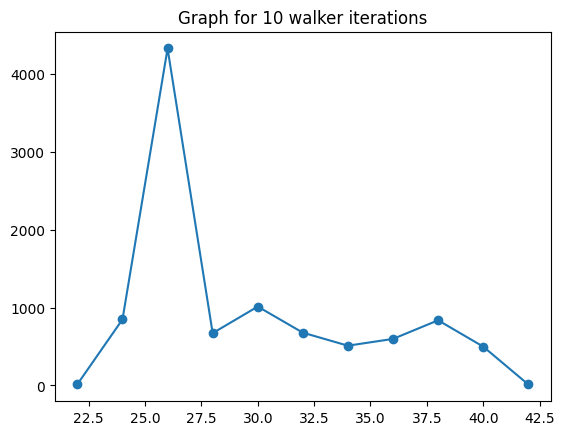

In [47]:
# graph for 10 walker iterations
def graph(final):

    x_arr = list(final.keys())
    y_arr = [dict(final)[j] for j in dict(final).keys()]

    x_arr_final = []
    y_arr_final = []

    while len(x_arr) > 0:

        x_arr_final.append(min(x_arr))
        y_arr_final.append(y_arr[x_arr.index(min(x_arr))])
        holder = x_arr.index(min(x_arr))
        del x_arr[holder]
        del y_arr[holder]

    plt.plot(x_arr_final, y_arr_final)
    plt.scatter(x_arr_final, y_arr_final)
    plt.show()

plt.title("Graph for 10 walker iterations")
graph(final)

In [48]:
# 20 steps
iterator = 20

final = generate_walk(number_qubits, iterator, sample_number)
print(final)

Counter({20: 2830, 18: 1809, 26: 769, 24: 746, 46: 636, 42: 406, 28: 376, 30: 325, 32: 314, 34: 312, 22: 290, 44: 271, 36: 265, 38: 186, 16: 184, 40: 154, 48: 122, 50: 3, 14: 2})


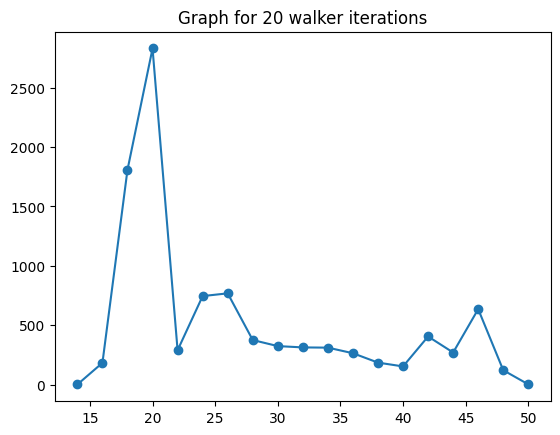

In [49]:
# graph for 20 walker iterations
plt.title("Graph for 20 walker iterations")
graph(final)

In [50]:
# 30 steps
iterator = 30

final = generate_walk(number_qubits, iterator, sample_number)
print(final)

Counter({12: 2431, 14: 1258, 20: 674, 16: 588, 10: 588, 52: 529, 18: 418, 48: 339, 22: 331, 54: 268, 28: 258, 30: 253, 40: 251, 26: 237, 32: 216, 42: 210, 36: 200, 24: 195, 38: 190, 34: 183, 44: 133, 46: 118, 50: 53, 8: 46, 56: 31, 6: 2})


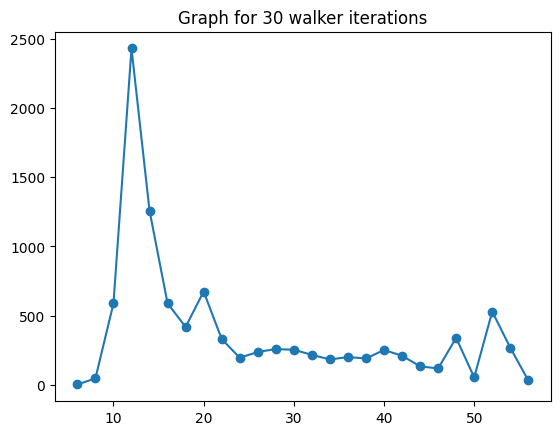

In [51]:
# graph for 30 walker iterations
plt.title("Graph for 30 walker iterations")
graph(final)

In [52]:
# classical random walker

# 10 steps

# Defines all of the necessary parameters
N = 10  # Defines the total number of steps our walker will take
pr = 0.5  # Defines the probability of our walker stepping to the right
i = 0  # Defines the initial position of our walker


def random_walk(pr, N, i):

    position = i

    # Repeatedly queries our random variable and moves our walker for the specified number of steps

    for j in range(N):

        coin_flip = list(np.random.choice(2, 1, p=[1 - pr, pr]))  # Flips our weighted coin
        position += 2 * coin_flip[0] - 1  # Moves our walker according to the coin flip

    return position


print("The walker is located at: x = {var}".format(var=random_walk(pr, N, i)))

The walker is located at: x = 2


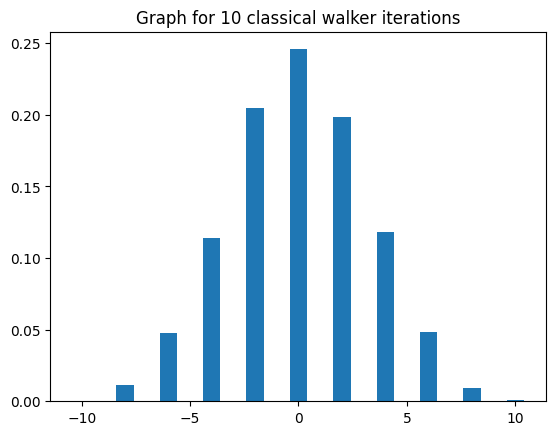

In [53]:
# classical random walker graph for 10 steps
def dist(runs, N):

    positions = range(-1 * N, N + 1)
    instances = [0 for i in range(-1 * N, N + 1)]

    for k in range(runs):

        result = random_walk(pr, N, i)
        instances[positions.index(result)] += 1

    plt.bar(positions, [n / runs for n in instances])
    plt.show()

plt.title("Graph for 10 classical walker iterations")
dist(10000, N)

In [54]:
# classifcal random walker 20 steps

N = 20  # Defines the total number of steps our walker will take
print("The walker is located at: x = {var}".format(var=random_walk(pr, N, i)))


The walker is located at: x = -6


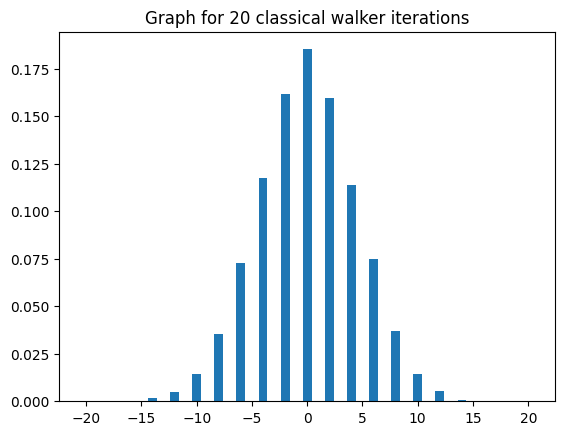

In [55]:
# classical random walker graph for 20 steps
plt.title("Graph for 20 classical walker iterations")
dist(10000, N)

In [56]:
# classical random walker 30 steps

N = 30  # Defines the total number of steps our walker will take
print("The walker is located at: x = {var}".format(var=random_walk(pr, N, i)))


The walker is located at: x = 6


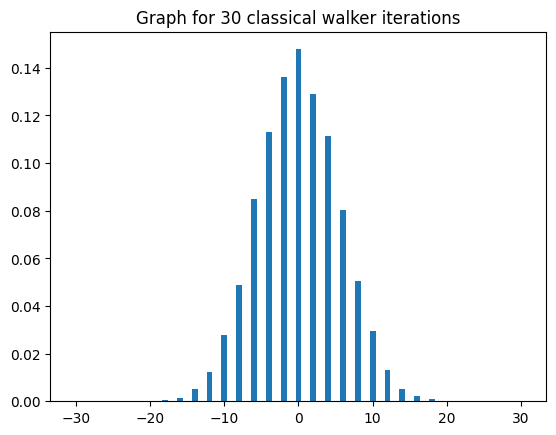

In [57]:
# classical random walker graph for 30 steps
plt.title("Graph for 30 classical walker iterations")
dist(10000, N)

Comment on the distributions you obtained:

How do they compare to the classical random walk?
- The quantum walks show highly localised or skewed shapes that do not resemble the classical bell curve, while the classical walks all display a bell-shpaed probability distribution centered at the origin. Even as the number of steps increases, the distribution gets wider but retains this symmetric shape.
- This suggests that the the quantum circuit is not capturing the interference or summetrical superposition expected of a proper quantum walk.

Are they symmetric?
- No, the probability distributions obtained for the quantum walks are not symmetric. The graphs are biased. Most of the probability is concentrated on one side of the walker’s position space, with a few smaller peaks scattered but no balanced fall-off on both sides.
- This asymmetry suggests that either the quantum walk circuit is not perfectly balanced, the initial state is not centered correctly, or the coin and shift operations create a directional preference.
- For the discrete quantum walk to produce a symmetric distribution, both the initial state and the coin flip must be unbiased and the evolution must treat movement in both directions equivalently.
- The graphical outputs of the quantum walk circuits here indicate a flaw in one of these elements, preventing the walker from exploring right and left with equal probability and leading to an asymmetric distribution.

Is the walk faster, slower, or slower than the classical random walk?
- The classical walker appears to spread more broadly with increasing steps, while the quantum walker remains localised and does not spread as fast in this current implementation, suggesting that the quantum walk could actually be slower than the classical work in terms of speed.

What is the quantum effect that impacts the quantum walk?
- Quantum walks are defined by quantum superposition and quantum interference.
- At each step, the walker moves left and right simultaneously, and the probability amplitudes for different paths overlap, causing constructive and destructive interference. This quantum effect leads to pronounced peaks and valleys, greater spread, and faster propagation than classical walks.

We note that our current implementation may be lacking proper interference, which could be due to issues in the coin operation, shift logic, or initial state setup. When correctly implemented, we expect that interference produces distributions with multiple peaks and greater spread than the classical Gaussian shape.

## Task B.3 - Initial Condition in Superposition

Counter({124: 1179, 30: 1019, 28: 819, 126: 650, 36: 635, 26: 581, 38: 431, 122: 354, 4: 325, 0: 285, 34: 285, 68: 267, 32: 253, 2: 198, 64: 176, 6: 153, 70: 147, 12: 142, 42: 138, 14: 138, 44: 132, 10: 132, 46: 122, 16: 117, 58: 116, 56: 115, 24: 115, 20: 112, 48: 104, 52: 104, 54: 96, 8: 95, 18: 88, 50: 84, 22: 72, 62: 62, 40: 55, 60: 51, 120: 24, 66: 19, 72: 8, 118: 2})


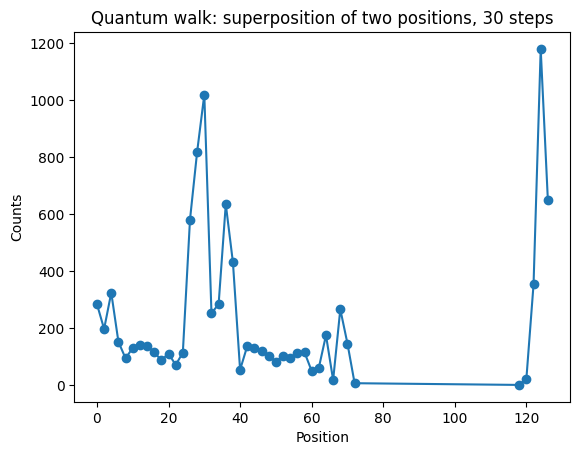

In [59]:
number_qubits = 7
qubits = cirq.GridQubit.rect(1, number_qubits)
coin_qubit = cirq.GridQubit(0, number_qubits)
all_qubits = list(qubits) + [coin_qubit]
iterator = 30
sample_number = 10000

# Initialize the position register in a superposition of |1> and |2>
def initial_state_superposed():
    # Prepare |1>
    yield cirq.X.on(cirq.GridQubit(0, 1))
    # Prepare |2>
    yield cirq.X.on(cirq.GridQubit(0, 2))
    # Hadamard on one of the two qubits to create (|1> + |2>)/sqrt(2)
    yield cirq.H.on(cirq.GridQubit(0, 1))
    # Coin register initialized in |1> (down arrow state)
    yield cirq.X.on(coin_qubit)

def walk_step():
    # "Flip" the coin vector
    yield cirq.H.on(coin_qubit)
    # Addition operator
    yield cirq.X.on(coin_qubit)
    for i in range(number_qubits, 0, -1):
        controls = [cirq.GridQubit(0, v) for v in range(number_qubits, i - 1, -1)]
        yield cirq.X.on(cirq.GridQubit(0, i - 1)).controlled_by(*controls)
        if i > 1:
            yield cirq.X.on(cirq.GridQubit(0, i - 1))
    yield cirq.X.on(coin_qubit)
    # Subtraction operator
    for i in range(1, number_qubits + 1):
        controls = [cirq.GridQubit(0, v) for v in range(number_qubits, i - 1, -1)]
        yield cirq.X.on(cirq.GridQubit(0, i - 1)).controlled_by(*controls)
        if i < number_qubits:
            yield cirq.X.on(cirq.GridQubit(0, i))

def generate_walk(number_qubits, iterator, sample_number):
    circuit = cirq.Circuit()
    circuit.append(initial_state_superposed())
    for j in range(iterator):
        circuit.append(walk_step())
    circuit.append(cirq.measure(*qubits, key='x'))
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=sample_number)
    final = result.histogram(key='x')
    return final

final = generate_walk(number_qubits, iterator, sample_number)
print(final)

# Plot the distribution
def graph(final):
    x_arr = list(final.keys())
    y_arr = [dict(final)[j] for j in dict(final).keys()]
    x_arr_final = []
    y_arr_final = []
    while len(x_arr) > 0:
        x_arr_final.append(min(x_arr))
        y_arr_final.append(y_arr[x_arr.index(min(x_arr))])
        holder = x_arr.index(min(x_arr))
        del x_arr[holder]
        del y_arr[holder]
    plt.plot(x_arr_final, y_arr_final)
    plt.scatter(x_arr_final, y_arr_final)
    plt.title("Quantum walk: superposition of two positions, 30 steps")
    plt.xlabel("Position")
    plt.ylabel("Counts")
    plt.show()

graph(final)


Compare the distribution to the distributions of Task B.3.:

Previous quantum walk distributions showed one major region of probability concerntraqtion while the distributions of Task B.3. shows two major regions of probability concentration - one peak around position 32, and an even large around position 128, with much much lower probabilities in between.

This indicates that the quantum walk's evolution strongly preserves the memory of its initial positions, and interference between the two evolving wave packets causes more pronounced peaks and deeper troughs.

## Task B.4 - ROTY and Biased Quantum Walk

Counter({8: 2950, 6: 1930, 12: 905, 14: 576, 22: 303, 20: 299, 58: 275, 24: 205, 18: 196, 4: 181, 48: 178, 10: 164, 54: 162, 26: 152, 56: 146, 16: 145, 34: 138, 32: 127, 50: 127, 28: 124, 46: 114, 30: 112, 36: 111, 38: 100, 40: 79, 42: 61, 44: 59, 60: 51, 52: 28, 2: 2})


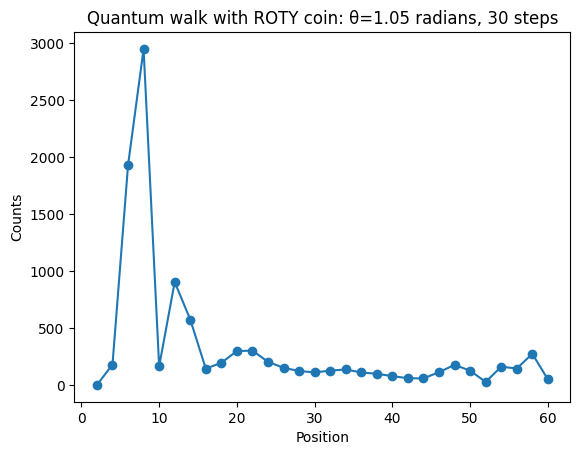

In [61]:
# 30 steps for quantum walk with ROTY
number_qubits = 7
qubits = cirq.GridQubit.rect(1, number_qubits)
coin_qubit = cirq.GridQubit(0, number_qubits)
iterator = 30
sample_number = 10000

# theta = π/3 introduces bias; theta = π/2 is unbiased (Hadamard-like)
theta = np.pi / 3

def initial_state():
    yield cirq.X.on(cirq.GridQubit(0, 1))
    yield cirq.X.on(coin_qubit)

def walk_step():
    # "Flip" the coin vector (ROTY coin)
    yield cirq.ry(theta).on(coin_qubit)
    # Implement the Addition Operator
    yield cirq.X.on(coin_qubit)
    for i in range(number_qubits, 0, -1):
        controls = [cirq.GridQubit(0, v) for v in range(number_qubits, i - 1, -1)]
        yield cirq.X.on(cirq.GridQubit(0, i - 1)).controlled_by(*controls)
        if i > 1:
            yield cirq.X.on(cirq.GridQubit(0, i - 1))
    yield cirq.X.on(coin_qubit)
    # Implement the Subtraction Operator
    for i in range(1, number_qubits + 1):
        controls = [cirq.GridQubit(0, v) for v in range(number_qubits, i - 1, -1)]
        yield cirq.X.on(cirq.GridQubit(0, i - 1)).controlled_by(*controls)
        if i < number_qubits:
            yield cirq.X.on(cirq.GridQubit(0, i))

def generate_walk(number_qubits, iterator, sample_number):
    circuit = cirq.Circuit()
    circuit.append(initial_state())
    for j in range(iterator):
        circuit.append(walk_step())
    circuit.append(cirq.measure(*qubits, key='x'))

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=sample_number)
    final = result.histogram(key='x')
    return final

final = generate_walk(number_qubits, iterator, sample_number)
print(final)

# Plot the distribution
def graph(final):
    x_arr = list(final.keys())
    y_arr = [dict(final)[j] for j in dict(final).keys()]
    x_arr_final = []
    y_arr_final = []
    while len(x_arr) > 0:
        x_arr_final.append(min(x_arr))
        y_arr_final.append(y_arr[x_arr.index(min(x_arr))])
        holder = x_arr.index(min(x_arr))
        del x_arr[holder]
        del y_arr[holder]
    plt.plot(x_arr_final, y_arr_final)
    plt.scatter(x_arr_final, y_arr_final)
    plt.title(f"Quantum walk with ROTY coin: θ={theta:.2f} radians, {iterator} steps")
    plt.xlabel("Position")
    plt.ylabel("Counts")
    plt.show()

graph(final)


How does changing the coin operator affect the probability distribution?
- Changing the coin operator in a quantum walk directly alters the walker's probability distribution by controlling the superposition and relative amplitudes for moving left or right at each step.
- The unbiased coin (with the Hadamard gates in the quantum graphs in Tasks B.1 and B.2) produces a balanced superposition, leading to ideally symmetric probability distributions and maximal quantum interference. Typically, it is expected that the walker spreads ballistically, with mulitple peaks and valleys due to interference, but the distribution should be centered around the initial position.
- The biased coin (with e.g. ROTY in Task B.3), skews the superposition, favouring one direction over another. This results in an asymmetric probability distribution, with the walker more likely to be found on one side of the position space.

How would you design a biased quantum walk using this method?
- We designed a biased quantum walk by changing the coin operator from an unbiased Hadamard to a biased ROTY.

e.g.
yield cirq.ry(theta).on(coin_qubit)  

We note that theta < pi/2 biases left, theta > pi/2 biases right.
- When we ran the experiment we designed for the biased quantum walk above, we noted that the walker drifted towards the left, which logically aligns with our input of theta as π/3.

# AI Assistance Disclosure

Generally, ChatGPT was used to guide us in the debugging of code.

**Per-Task Usage:**  
- **Task 1:**

Query: "i dont see any visual change with the circle notations displayed"

Answer: "You did...

Each basis state has probability 1/4.

So each circle will show a disk of equal size (since all probs = 0.25).

The arrows all point the same way (phase = 0).

👉 That’s why it “looks the same” across circles."

- **Task 2:**

Query: "help me interpret the circuit in the image below..."

Answer: "Each qubit gets a Hadamard... That creates an equal superposition of all basis states so amplitudes have equal magnitude.

The diagram also shows a phase/rotation applied during prep..."

- **Bonus:**
GPT was used in helping to understand concepts surrounding quantum walks, coin operators and resulting probability distributions.

**Validation:** AI outputs were tested in the notebook, adapted to match variable names and environment, and checked with documentation and sample data to ensure correctness.

